<a href="https://colab.research.google.com/github/tutsilianna/Introduction_to_ML_and_Advanced_ML_Python/blob/main/Support%20Vector%20Machine%20(SVM)/Support_Vector_Machine_(SVM)_%7C_Exercise_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face recognition using SVM and kernel trick

# Dataset description

This assignment asks you to build a classifier trained on face images. First, let's load the required [dataset](https://drive.google.com/file/d/1sNinlZ2MryAeGV4DIdNQRppF-dricETl/view?usp=sharing) and see what it is.

The table contains "straightened" representations of images of people's faces.

Initially, each image is a matrix of size $62 \times 47$ whose values are presumably normalized to a range $[0, 1]$ from the range $[0, 255] \cap \mathbb Z$. The values themselves are responsible for the intensity of the pixel: the larger the value, the lighter the pixel.

Note, from the image (or, what is the same thing, matrix) of size $62 \times 47$ we get a vector of $2914 = 62 \cdot 47$ length.

The column <code>label</code> is responsible for the name of the person depicted in the picture.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/itmo|AI_cources/persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Let's make sure that we actually see images of people's faces. Let's take the first $15$ rows from the initial dataframe and build the images corresponding to them.

In [4]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

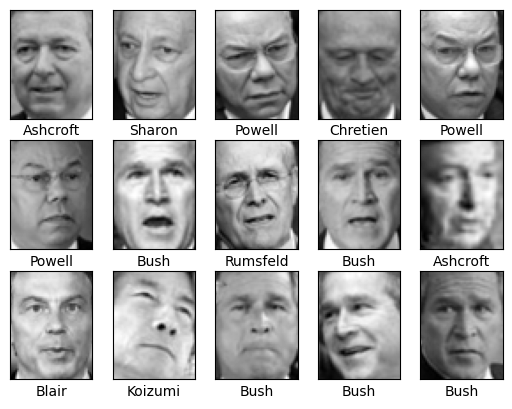

In [5]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Larger

(-0.5, 46.5, 61.5, -0.5)

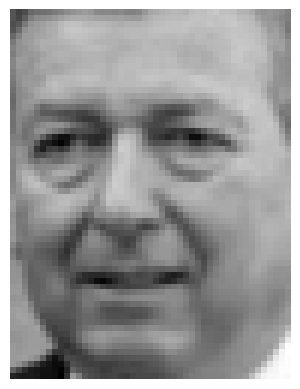

In [6]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# A bit of mischief

Determine the number of different people whose pictures are contained in the dataset.

In [7]:
df['label'].value_counts()

George W Bush        451
Colin Powell         201
Tony Blair           122
Donald Rumsfeld      103
Gerhard Schroeder     93
Ariel Sharon          65
Hugo Chavez           60
Junichiro Koizumi     51
Jean Chretien         47
John Ashcroft         45
Serena Williams       44
Jacques Chirac        44
Name: label, dtype: int64

In [8]:
len(df['label'].value_counts())

12

Construct a histogram of the distribution of objects by class and calculate the proportion of objects in each class.

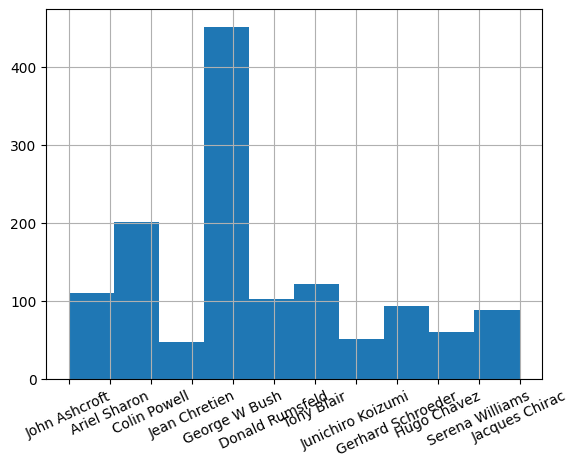

In [9]:
df['label'].hist(xrot=25);

Enter the proportion of objects in class `Jacques Chirac`.

In [10]:
round(df[df['label'] == 'Jacques Chirac'].shape[0] / df.shape[0], 3)

0.033

Based on the available data, match each person with one vector whose coordinates are the average of the corresponding coordinates of all vectors identified with that person.

In [11]:
df[df['label'] == 'Jacques Chirac']

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
46,0.201307,0.240523,0.335948,0.351634,0.342484,0.373856,0.396078,0.413072,0.445752,0.474510,...,0.218301,0.377778,0.400000,0.152941,0.101961,0.109804,0.075817,0.056209,0.058824,Jacques Chirac
61,0.022222,0.022222,0.024837,0.044444,0.087582,0.156863,0.215686,0.245752,0.298039,0.362092,...,0.739869,0.443137,0.398693,0.405229,0.368627,0.368627,0.380392,0.388235,0.381699,Jacques Chirac
76,0.535948,0.530719,0.524183,0.529412,0.533333,0.533333,0.535948,0.552941,0.568627,0.579085,...,0.534641,0.724183,0.844444,0.831373,0.864052,0.865359,0.742484,0.422222,0.363399,Jacques Chirac
131,0.849673,0.687582,0.562091,0.542484,0.439216,0.377778,0.383007,0.430065,0.487582,0.541176,...,0.318954,0.294118,0.264052,0.233987,0.220915,0.239216,0.291503,0.316340,0.307190,Jacques Chirac
143,0.547712,0.533333,0.482353,0.457516,0.486274,0.492810,0.492810,0.532026,0.568627,0.605229,...,0.708497,0.734641,0.674510,0.742484,0.913726,0.975163,0.975163,0.962091,0.963399,Jacques Chirac
157,0.309804,0.392157,0.469281,0.505882,0.518954,0.526797,0.537255,0.551634,0.581699,0.609150,...,0.304575,0.307190,0.309804,0.316340,0.325490,0.345098,0.358170,0.384314,0.423529,Jacques Chirac
166,0.623529,0.619608,0.666667,0.708497,0.738562,0.763399,0.785621,0.785621,0.797386,0.805229,...,0.562091,0.771242,0.904575,0.913725,0.932026,0.943791,0.922876,0.611765,0.313725,Jacques Chirac
189,0.471895,0.583007,0.688889,0.798693,0.849673,0.858824,0.843137,0.823529,0.833987,0.848366,...,0.351634,0.316340,0.352941,0.222222,0.117647,0.158170,0.183007,0.253595,0.312418,Jacques Chirac
225,0.475817,0.508497,0.521569,0.542484,0.563399,0.571242,0.562091,0.580392,0.628758,0.667974,...,0.984314,0.788235,0.397386,0.393464,0.452288,0.454902,0.458824,0.465359,0.469281,Jacques Chirac
229,0.325490,0.354248,0.376471,0.401307,0.430065,0.460131,0.478431,0.478431,0.500654,0.532026,...,0.369935,0.389543,0.406536,0.474510,0.752941,0.783007,0.686275,0.675817,0.551634,Jacques Chirac


In [12]:
persons = list(df['label'].unique())

In [13]:
import numpy as np

vector_a = {}

for person in persons:
    coord = []
    for column in df.columns:
        if column != 'label':
            coord.append(np.average(df.loc[df['label'] == person,column]))
    vector_a[person] = coord

data = pd.DataFrame(data=vector_a)
data

,John Ashcroft,Ariel Sharon,Colin Powell,Jean Chretien,George W Bush,Donald Rumsfeld,Tony Blair,Junichiro Koizumi,Gerhard Schroeder,Hugo Chavez,Serena Williams,Jacques Chirac
0,0.337894,0.501398,0.433512,0.388958,0.348179,0.404810,0.327922,0.268384,0.210162,0.206885,0.412983,0.348010
1,0.334379,0.514811,0.441147,0.412488,0.360263,0.417260,0.342955,0.253672,0.228210,0.205142,0.390434,0.368152
2,0.337662,0.532609,0.456248,0.446614,0.381659,0.442731,0.363163,0.249699,0.268255,0.240828,0.359091,0.405704
3,0.357037,0.551714,0.471947,0.487637,0.416669,0.474028,0.401854,0.257875,0.328344,0.300806,0.333541,0.436988
4,0.384779,0.569754,0.486730,0.526158,0.457154,0.507938,0.456177,0.297373,0.389332,0.370196,0.337136,0.462686
...,...,...,...,...,...,...,...,...,...,...,...,...
2909,0.540944,0.515656,0.510006,0.455180,0.459067,0.525947,0.552277,0.537896,0.482550,0.392309,0.308200,0.537998
2910,0.534524,0.498220,0.477586,0.426060,0.447653,0.500603,0.542077,0.532359,0.442252,0.384989,0.322460,0.542751
2911,0.524415,0.486657,0.448119,0.415353,0.430523,0.475550,0.516072,0.516750,0.428477,0.371503,0.334492,0.505853
2912,0.527495,0.466928,0.410659,0.414713,0.399620,0.431893,0.480853,0.498347,0.426875,0.372440,0.348247,0.456625


Enter the coordinate with index $0$ of the average vector corresponding to `Gerhard Schroeder`.

In [14]:
round(data['Gerhard Schroeder'][0], 3)

0.21

Using the average vectors, construct pictures of all the people in the dataset.

In [15]:
data1 = data.copy(deep=True)

data = data.T

data['label'] = list(data.index)
data.index = np.arange(len(data))

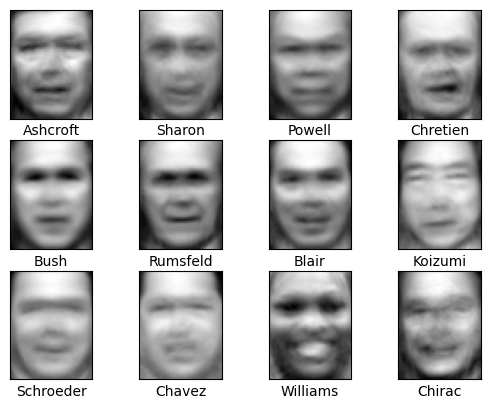

In [16]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(data.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

The so-called [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) is often used as a measure of the "similarity" of two objects. It should not be confused with cosine distance.

Construct a similarity matrix of objects based on their averaged vectors. We recommend using a heat map for visualization, e.g. [from the seaborn library](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [17]:
import seaborn as sns

In [18]:
from scipy.spatial.distance import pdist,squareform

matrix = 1/(1+squareform(pdist(data1.T, metric='cosine')))

In [19]:
matrix

array([[1.        , 0.99515453, 0.99630882, 0.99394406, 0.99747137,
        0.99533002, 0.99691778, 0.99367185, 0.99699487, 0.99482103,
        0.98751175, 0.99618647],
       [0.99515453, 1.        , 0.99785842, 0.99599347, 0.99484039,
        0.99676258, 0.99538357, 0.98796276, 0.99345779, 0.98971849,
        0.98792152, 0.99321844],
       [0.99630882, 0.99785842, 1.        , 0.99650244, 0.99642189,
        0.99770524, 0.99737406, 0.99049979, 0.99549041, 0.99282756,
        0.98850339, 0.99515441],
       [0.99394406, 0.99599347, 0.99650244, 1.        , 0.99355797,
        0.99745465, 0.99586754, 0.98636051, 0.99415271, 0.98999127,
        0.98307601, 0.9933937 ],
       [0.99747137, 0.99484039, 0.99642189, 0.99355797, 1.        ,
        0.99665634, 0.99733825, 0.9937073 , 0.99773357, 0.99636613,
        0.98551973, 0.99623746],
       [0.99533002, 0.99676258, 0.99770524, 0.99745465, 0.99665634,
        1.        , 0.99729891, 0.98871322, 0.99632262, 0.99201775,
        0.9867827 ,

In [20]:
index = list(data1.columns)

<Axes: >

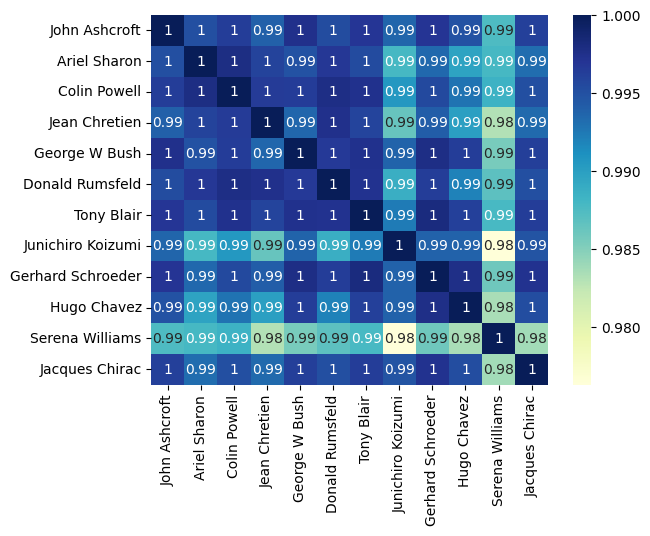

In [21]:
sns.heatmap(matrix, cmap="YlGnBu", annot = True, xticklabels = index, yticklabels = index);

Enter the value of the cosine similarity between a pair of averaged vectors `Donald Rumsfeld` and `Serena Williams`

In [22]:
round(matrix[5][10],3)

0.987

# Model building

Use <code>train_test_split()</code> to split the dataset into training and test samples with the parameters `test_size=0.2, random_state=5`. Use stratification by column <code>label</code>.

In [23]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=5, stratify=df['label'])

In [24]:
y_train = train['label']
y_test = test['label']

X_train = train.drop(axis=1, columns=['label'])
X_test = test.drop(axis=1, columns=['label'])

## First approximation: a basic SVM classifier with a linear kernel

Train the <code>SVC()</code> model on the training dataset with the following parameters: `kernel='linear', random_state=5`.

In [25]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=5).fit(X_train, y_train)

Evaluate the model on test dataset. Compute <code>f1_score(average='weighted')</code>.

In [26]:
from sklearn.metrics import f1_score

y_pred = svm.predict(X_test)
round(f1_score(y_test, y_pred, average='weighted'), 3)

0.741

Overall, a pretty good result, but it makes sense to try to tweak the parameters.

## Selection of hyperparameters

Using GridSearchCV(), perform a hyperparameter selection based on the following values:

```
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
```

In [27]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[5]}]

In [28]:
svc = SVC()
cv = GridSearchCV(svc, tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   1.4s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   1.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   1.4s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   1.5s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   1.3s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   1.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   1.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   1.5s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

Determine the parameters of the <b>best</b> learned model.

In [29]:
cv.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'sigmoid',
 'random_state': 5}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [30]:
y_pred1 = cv.predict(X_test)
round(f1_score(y_test, y_pred1, average='weighted'), 3)

0.771

## Dimensionality reduction

Learning took a long time. It makes sense to test what happens if you reduce the dimensionality of the input dataset, e.g. by using <code>PCA</code>. Train the <code>PCA(svd_solver='full')</code> model on the training dataset and determine the minimum number of components required for the explained variance ratio to be greater than <code>0.95</code>.

In [31]:
df_pca = df.copy(deep=True)

df_pca.drop(axis=True, columns=['label'], inplace=True)

In [48]:
from sklearn.decomposition import PCA

n = 100
pca = PCA(n_components=n, svd_solver='full').fit(X_train)

while sum(pca.explained_variance_ratio_)  < 0.95:
    n += 1
    pca = PCA(n_components=n, svd_solver='full').fit(X_train)
print(n)

173


Re-train the <code>PCA(svd_solver='full')</code> model on the training dataset using the resulting number of principal components. Apply the resulting transformation to the training and test datasets.

In [50]:
pca_ = PCA(n_components=n, svd_solver='full').fit(X_train)

df_train = pca_.transform(X_train)
X_train1 = pd.DataFrame(df_train, columns=[str(i) for i in range(1, n+1)])
X_train1.head()

,1,2,3,4,5,6,7,8,9,10,...,164,165,166,167,168,169,170,171,172,173
0,0.083801,-1.036655,1.386186,1.325246,-0.940964,2.352169,-0.106192,-0.101512,0.027302,-0.993388,...,-0.204551,-0.130486,-0.022215,0.061945,0.233772,-0.111984,-0.196020,-0.009573,-0.202378,0.066583
1,0.576494,-1.293505,1.155102,0.883243,-2.583999,0.657785,0.395776,2.002862,-0.362235,-2.079536,...,-0.015452,0.049051,-0.131412,-0.181289,-0.229389,-0.243460,-0.116227,0.330286,-0.242622,0.098496
2,-4.699990,-0.750522,-1.770724,-2.567413,-2.271876,0.581663,0.026647,1.137326,0.591124,-0.991123,...,-0.111190,0.009318,-0.074734,-0.318519,-0.015549,0.032760,0.153108,-0.008632,-0.182625,0.081155
3,-5.824352,3.033387,-3.394875,-3.107620,-1.801394,0.944613,0.201961,-2.454867,-1.689008,0.647068,...,0.029740,0.298989,0.042657,0.125565,0.040174,-0.144879,0.203737,-0.223856,0.102974,-0.211081
4,-2.202157,-4.856443,-0.387306,0.968405,-0.497269,-1.466837,-2.134785,0.391574,0.505159,-1.615970,...,0.029372,-0.176954,-0.004229,-0.348889,-0.108376,-0.211608,-0.120576,0.107464,-0.221428,0.161504


In [51]:
df_test = pca.transform(X_test)
X_test1 = pd.DataFrame(df_test, columns=[str(i) for i in range(1, n+1)])
X_test1 .head()

,1,2,3,4,5,6,7,8,9,10,...,164,165,166,167,168,169,170,171,172,173
0,2.614384,1.885309,1.316936,-0.752517,0.273925,-0.463694,0.408341,2.500227,-1.885908,0.988356,...,-0.259820,-0.235467,0.181682,0.125573,0.109825,0.275824,0.090678,0.041752,0.021080,0.137542
1,12.747640,0.245029,-1.679958,0.226792,-0.573241,-0.831459,-0.054474,-0.327811,0.129030,-0.462658,...,0.163426,-0.110801,-0.269028,0.011299,-0.365512,0.083298,-0.022790,0.798258,-0.177523,-0.569989
2,-0.009890,0.952345,0.945056,0.235637,-1.831019,0.565871,-0.024244,-2.419530,2.471327,1.354537,...,0.555443,0.613407,-0.039639,-0.198909,0.462420,-0.042224,0.061450,-0.029854,0.106521,0.364021
3,1.051038,-2.667261,-0.435481,0.307526,0.119284,0.916103,1.557767,-0.204163,-0.304058,-0.755635,...,0.081705,-0.156011,0.029881,-0.059444,0.121670,0.017631,0.009922,-0.149085,-0.093413,0.192047
4,7.021688,0.113556,1.193653,-1.764266,0.456554,-2.159429,-1.962087,-0.285563,0.894611,-1.574924,...,0.241719,0.214535,-0.097700,-0.206087,0.393500,0.140806,-0.166425,0.151687,-0.112004,0.288034


For the data obtained after <code>PCA</code>, similarly to what was done earlier, i.e., using the <code>GridSearchCV()</code>, select hyperparameters from the ranges specified in your individual assignment. Pay special attention to model training time.

In [52]:
svc1 = SVC()
cv1 = GridSearchCV(svc1, tuned_parameters, refit=True, verbose=3)
cv1.fit(X_train1, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.6s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.5s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.5s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.7s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   1.0s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.5s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.3s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

Determine the parameters of the <b>best</b> model obtained.

In [53]:
cv1.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 5}

Perform prediction for the test dataset using the best model obtained. Compute <code>f1_score(average='weighted')</code>.

In [54]:
y_pred2 = cv1.predict(X_test1)
round(f1_score(y_test, y_pred2, average='weighted'), 3)

0.755

It can be seen that the quality of the model has changed only slightly, while the training time has decreased significantly.